# EDA: Comparison of Partial and Full Processing

This notebook is an exploratory analyses that compares the partially processed and the fully processed (wall to wall) TML data for select countries, including Rwanda, Guatemala, Malawi, El Salvador and Guinea Bissau.

**Area sampled (per land cover class)**
- An issue with the calculation of sampled and total hectares is persisting as the number of hectares per country seems too high.
- We expect and see in the results that the 'No Data' land cover class has a much higher count in the parital processing than in the full processing.
- We expect and see in the results that there is a much higher count of the tree cover (broadleaved/deciduous, broadleaved/evergreen) land cover class in the full processing.
- Subsets of certain land cover classes (same ESA label but different ESA ID number) were identified during this round of processing. This could result in a significantly higher count of hectares for the sampled and total area for a land cover class.
- If a land cover class does not appear in the visualization (a warning will print) it means that the country did not have data for that land cover class in the initial processing, but does include that land cover class in the full processing.

**Total hectares of tree cover (per land cover class)**
- we expect and see that the greatest differences in total hectares of tree cover are seen in the tree cover (broadleaved/deciduous, broadleaved/evergreen). This is logical given the full processing includes the non mosaic landscapes that were not included in the partial processing. 
- we also see an increase in the total hectares on cropland, which could be a result of the additional encoding/labeling of ESA ID's in that land cover category.
- Across the board we expect and see a decreases in hectares in the 'No Data' category (illustrated in red).
- Note: hectares of tree cover are not weighted by the percentage of tree cover within that hectare. A hectare with 10% tree cover is counted the same as a hectare with 90% tree cover.

**Mean tree cover (per land cover class)**
- Guinea Bissau has a surprisingly high average tree cover between 50-60% in cropland land cover types, whereas most countries hover in the 20-40% range.
- For all the countries included in this analysis, the average tree cover in urban areas increased with full processing. Tree cover in urban areas typically falls between 10-30%.
- Rwanda sees a large difference in the total hectares of tree cover in the rainfed cropland areas but is consistent in the mean cover for that land cover class.

**Forest cover compliant (per country)**
- El Salvador decreased by 1% on ag estimates and stayed the same on urban estimates. 
- Guatemala increased by 2% on ag estimates and decreased by 1% on urban estimates. 
- Guinea Bissau has the highest percentages of the countries analyzed thus far, with 85% of ag land and 75% of urban land meeting the forest cover criteria.


In [1]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd
import fiona

from rasterio.plot import show
from numpy.ma import masked_array

## Area sampled (per land cover class)

In [47]:
def compare_lc_sampled(country):
    
    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics.csv')

    # set up the dataframe and calculate area sampled
    full = full[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]
    full = full.drop_duplicates(keep='first', ignore_index=True)
    full['esa_not_sampled'] = full['esa_total_ha'] - full['esa_sampled_ha']
    full = full.groupby(by='esa_class').sum().reset_index()
    #full = full.sort_values(by='esa_sampled_ha')
    full['esa_perc_sampled'] = round((full['esa_sampled_ha'] / full['esa_total_ha']) * 100, 1)

    # apply the same to the partial 
    partial = partial[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]
    partial = partial.drop_duplicates(keep='first', ignore_index=True)
    partial['esa_not_sampled'] = partial['esa_total_ha'] - partial['esa_sampled_ha']
    partial = partial.groupby(by='esa_class').sum().reset_index()
    #partial = partial.sort_values(by='esa_sampled_ha')
    partial['esa_perc_sampled'] = round((partial['esa_sampled_ha'] / partial['esa_total_ha']) * 100, 1)
    
    print(f'Partial: {round(partial.esa_sampled_ha.sum(),1)} ha of {country} sampled.')
    print(f'Full: {round(full.esa_sampled_ha.sum(),1)} ha of {country} sampled.')
    
    # check for differences in lccs sampled
    full_classes = list(full.esa_class.values)
    partial_classes = list(partial.esa_class.values)
    list_difference = [item for item in partial_classes if item not in full_classes]
    if len(list_difference) > 0:
        partial.drop(partial[partial.esa_class == list_difference[0]].index, inplace = True)
        print(f'{list_difference} caused shape mismatch and was dropped from the partial dataset.')

    # create the position of the grouped bars
    width = 0.4
    pos1 = np.arange(len(full))
    pos2 = pos1 + width

    plt.figure(figsize=(15,9))

    # create the position of the stacked bars
    classes = list(full.esa_class.values)
    bars1 = full.esa_sampled_ha
    bars2 = full.esa_not_sampled
    bars3 = partial.esa_sampled_ha
    bars4 = partial.esa_not_sampled

    plt.barh(pos1, bars1, width, color="gold", edgecolor='white', label='sampled (full)')  
    plt.barh(pos1, bars2, width, left=bars1, color="darkslateblue", edgecolor='white', label='not sampled (full)')
    #f3e151
    #6c3376
    plt.barh(pos2, bars3, width, color="palegoldenrod", edgecolor='white', label='sampled (partial)')  
    plt.barh(pos2, bars4, width, left=bars3, color="slateblue", edgecolor='white', label='not sampled (partial)')

    plt.title(f'Land Cover Sampled in {country}')
    plt.xlabel('Tree Cover (ha)')
    plt.yticks(pos1 + width / 2, classes)
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend(loc='lower right');
    
    return None
    

Partial: 6194860.0 ha of Guatemala sampled.
Full: 15868520.6 ha of Guatemala sampled.


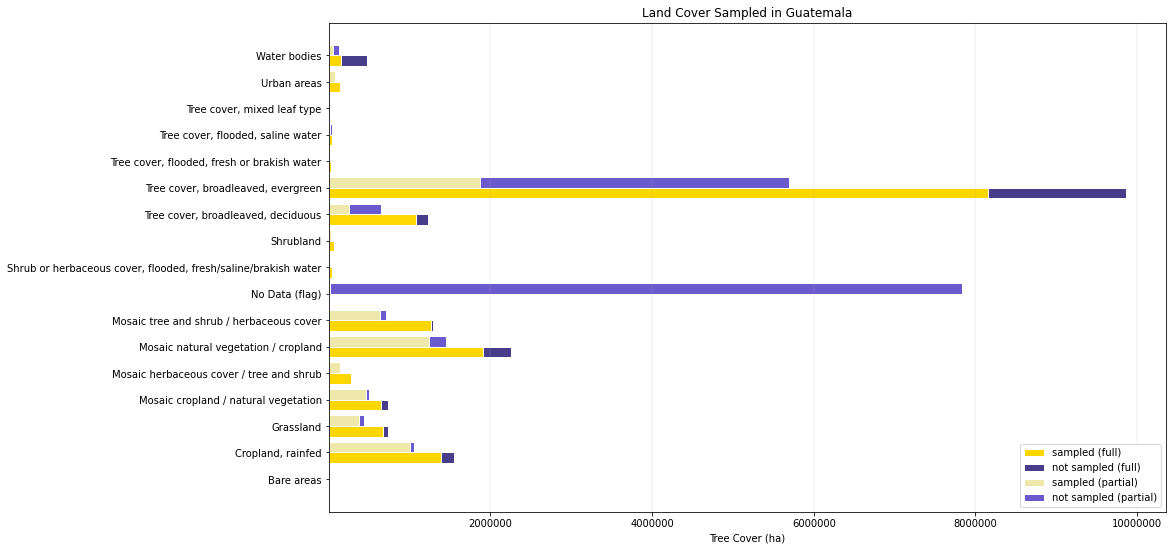

In [40]:
compare_lc_sampled("Guatemala")

Partial: 8091202.4 ha of Malawi sampled.
Full: 16254311.8 ha of Malawi sampled.


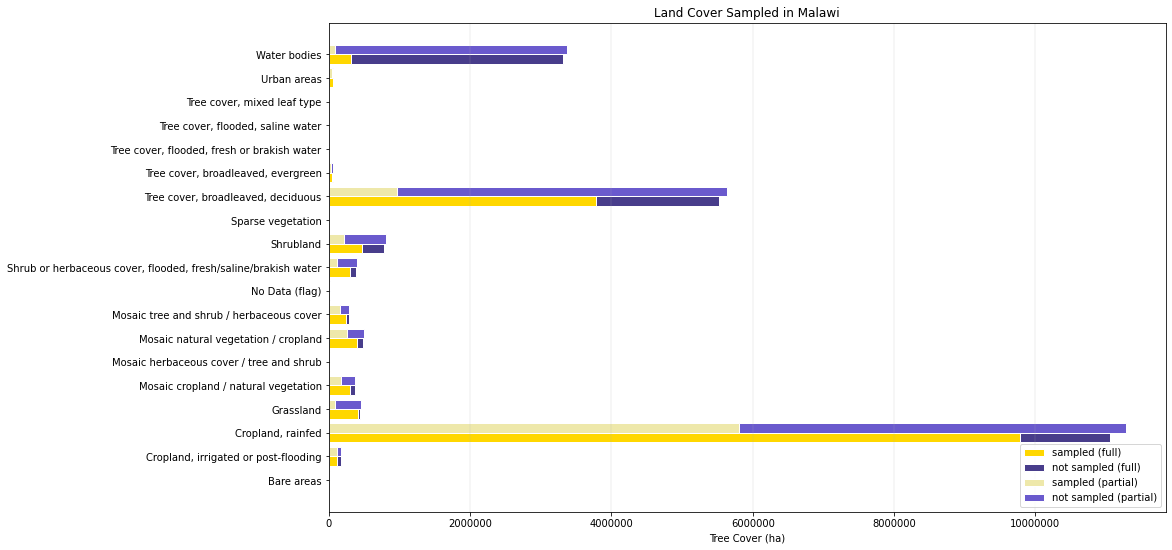

In [41]:
compare_lc_sampled('Malawi')

Partial: 1283182.9 ha of El Salvador sampled.
Full: 3628909.0 ha of El Salvador sampled.


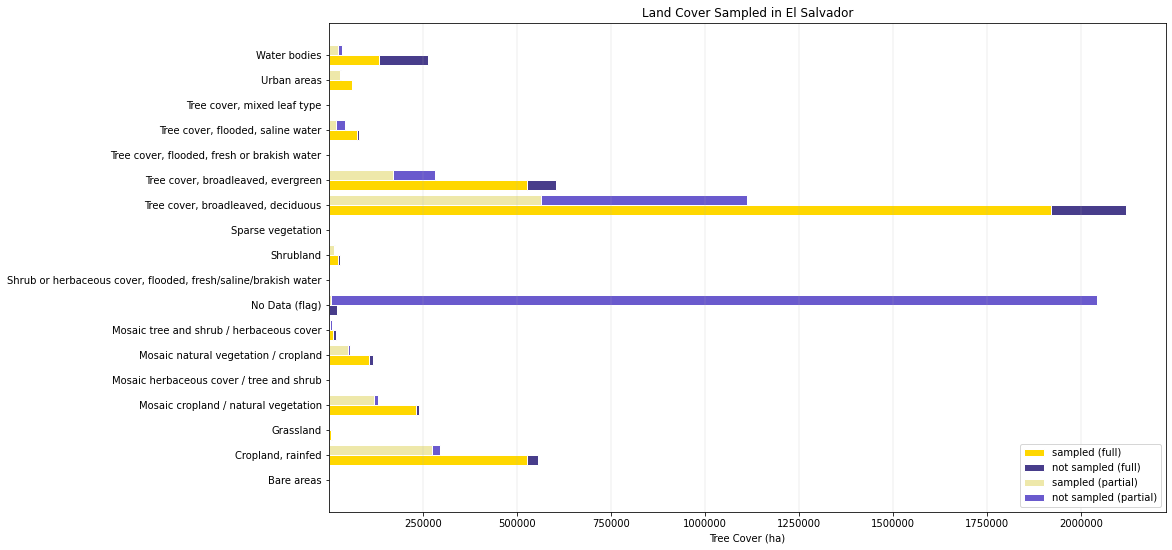

In [42]:
compare_lc_sampled('El Salvador')

Partial: 1138490.2 ha of Guinea Bissau sampled.
Full: 4757578.4 ha of Guinea Bissau sampled.


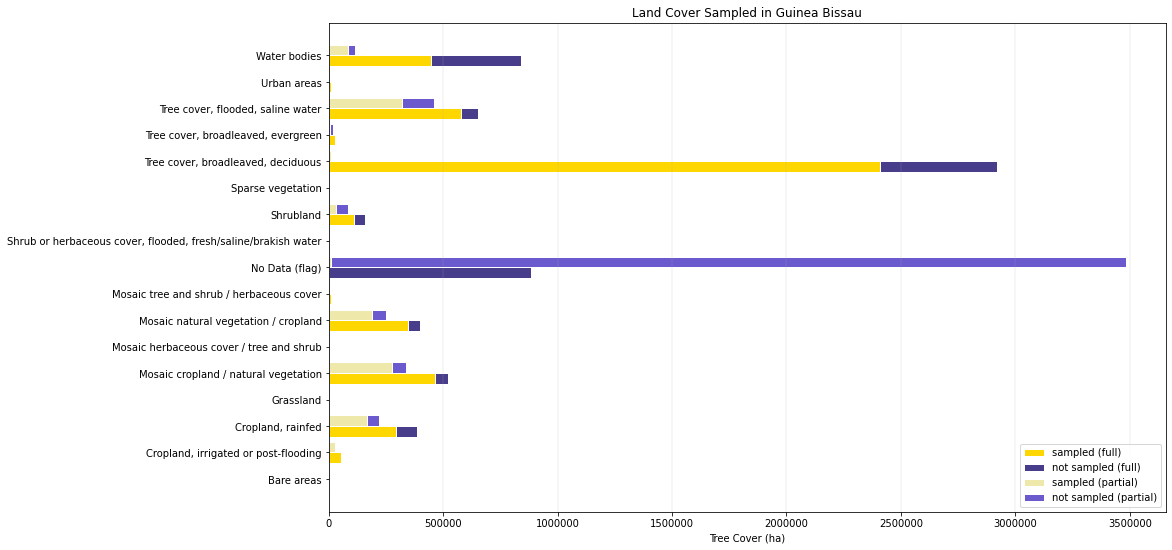

In [43]:
compare_lc_sampled('Guinea Bissau')

Partial: 1568405.5 ha of Rwanda sampled.
Full: 3317997.6 ha of Rwanda sampled.
['No Data (flag)'] caused shape mismatch and was dropped from the partial dataset.


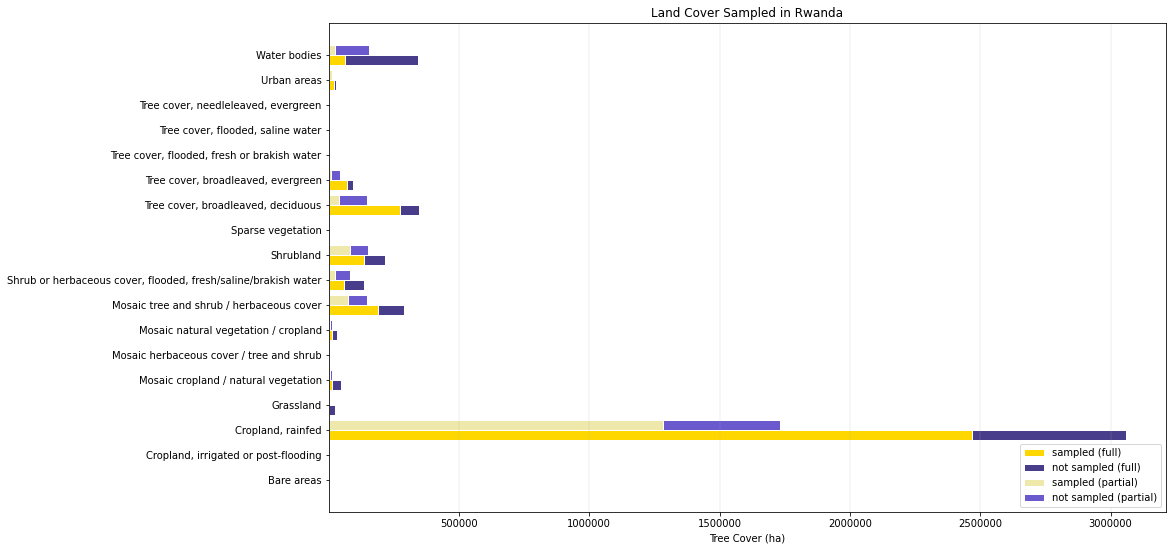

In [44]:
compare_lc_sampled('Rwanda')
# Rwanda has no data values in the partial class but not in the full class

## Total hectares of tree cover

In [50]:
def compare_lc_totalha(country):
    
    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics.csv')
    
    full_sum = full.groupby('esa_class').sum()
    full_sum = full_sum[['tof_ha', 'hans_ha']]
    partial_sum = partial.groupby('esa_class').sum()
    partial_sum = partial_sum[['tof_ha', 'hans_ha']]

    diverge_sum = full_sum - partial_sum
    colors = ['red' if x < 0 else 'green' for x in diverge_sum.tof_ha]

    plt.figure(figsize=(15,7))
    plt.hlines(y=diverge_sum.index,
               xmin=0,
               xmax=diverge_sum.tof_ha,
               alpha=0.7,
               linewidth=5,
               colors=colors)
               #label=str(diverge_sum.tof_ha))
    
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.title(f'Difference in total hectares per land cover class: {country}')
    plt.xlabel('tree cover (ha)');

#     x = diverge_sum.tof_ha.values
#     y = list(diverge_sum.index.values)
#     labels = [str(val) for val in diverge_sum.tof_ha.values]

#     for y_arr, label in zip(y, labels):
#         plt.plot(x, y_arr, label=label)

#     for label, loc in zip(diverge_sum.index, diverge_sum.tof_ha.values):
#         plt.text(label, loc, 'hello', ha ='left', va ='center')
    
    return None

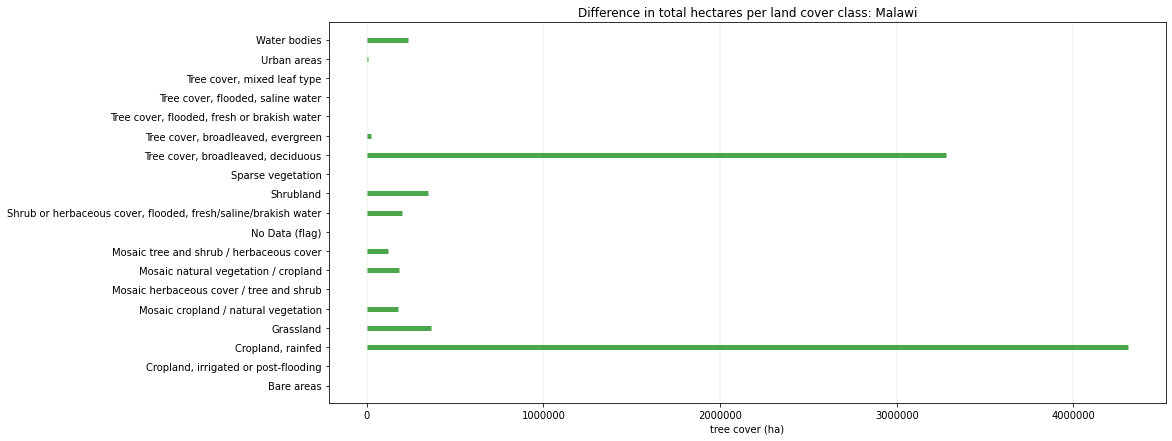

In [51]:
compare_lc_totalha('Malawi')

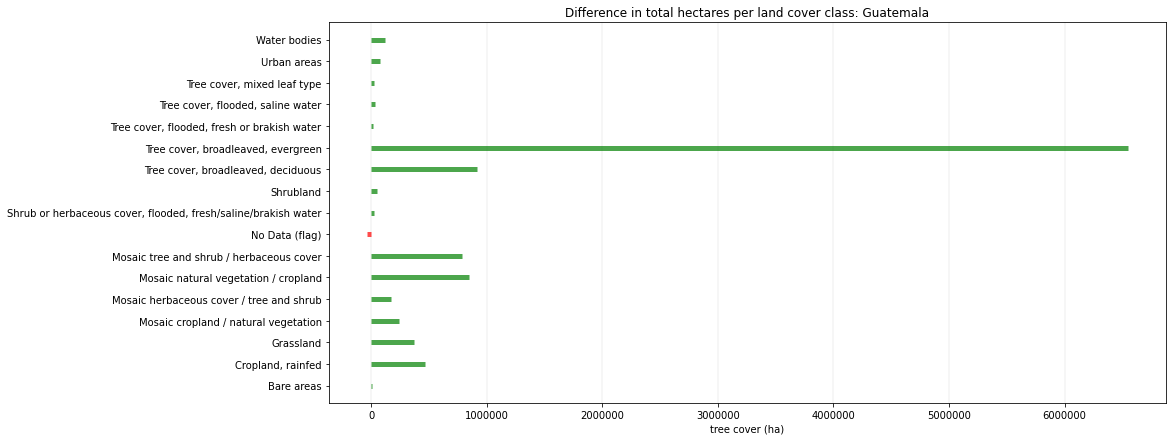

In [52]:
compare_lc_totalha('Guatemala')

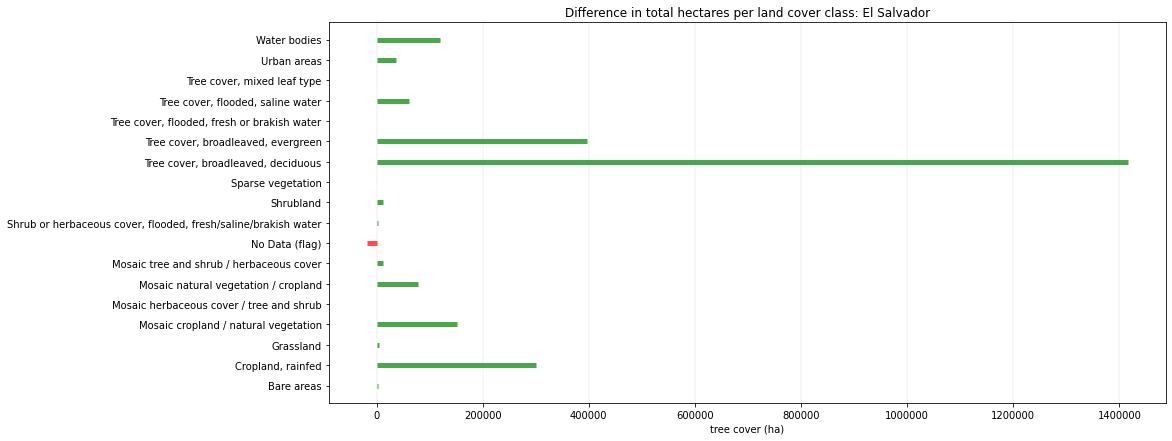

In [53]:
compare_lc_totalha('El Salvador')

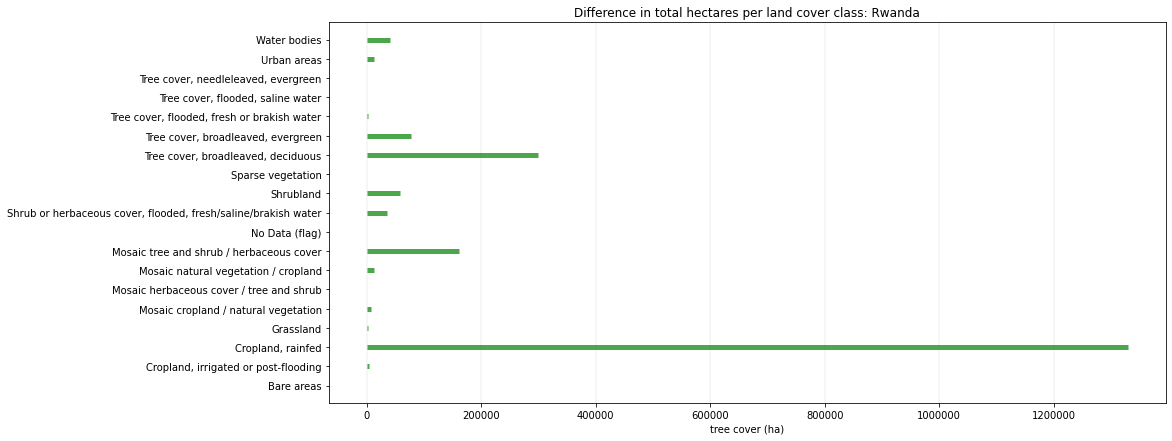

In [54]:
compare_lc_totalha('Rwanda')

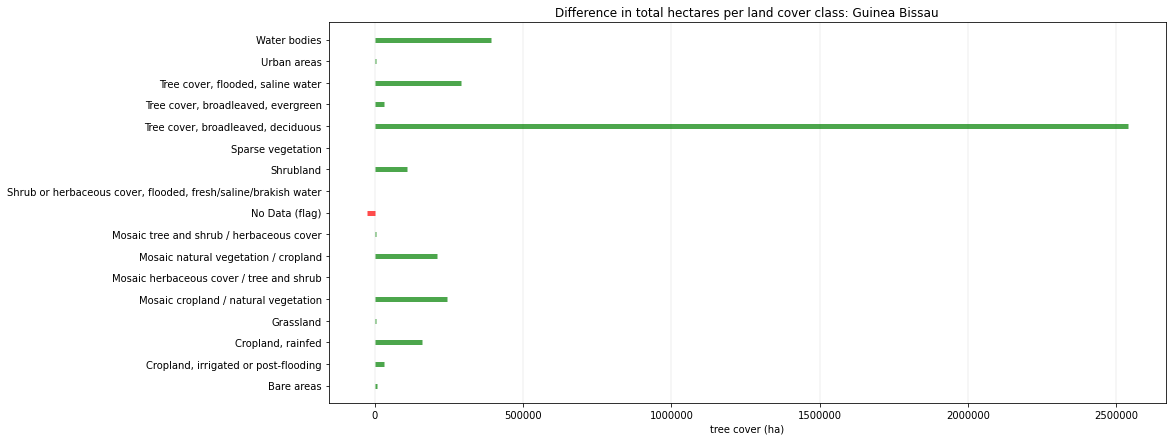

In [55]:
compare_lc_totalha('Guinea Bissau')

In [2]:
def compare_lc_mean(country):

    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics.csv')

    full_mean = full.groupby('esa_class').mean()
    full_mean = full_mean[['tof_mean']]
    partial_mean = partial.groupby('esa_class').mean()
    partial_mean = partial_mean[['tof_mean']]
    mean_merged = full_mean.merge(partial_mean, on='esa_class')

    plt.figure(figsize=(12,8))

    width = 0.4
    pos1 = np.arange(len(mean_merged))
    pos2 = pos1 + width

    plt.barh(pos1, mean_merged.tof_mean_x, width, color='gold', edgecolor='white', label='Full')
    plt.barh(pos2, mean_merged.tof_mean_y, width, color='palegoldenrod', edgecolor='white', label='Partial')

    plt.xlabel('% Tree Cover')
    plt.yticks(pos1 + width / 2, mean_merged.index.values)
    plt.title(f'Mean Tree Cover per Land Cover Class: {country}')
    plt.grid(axis='x', linestyle='-', linewidth=.3)
    plt.legend();

    return None

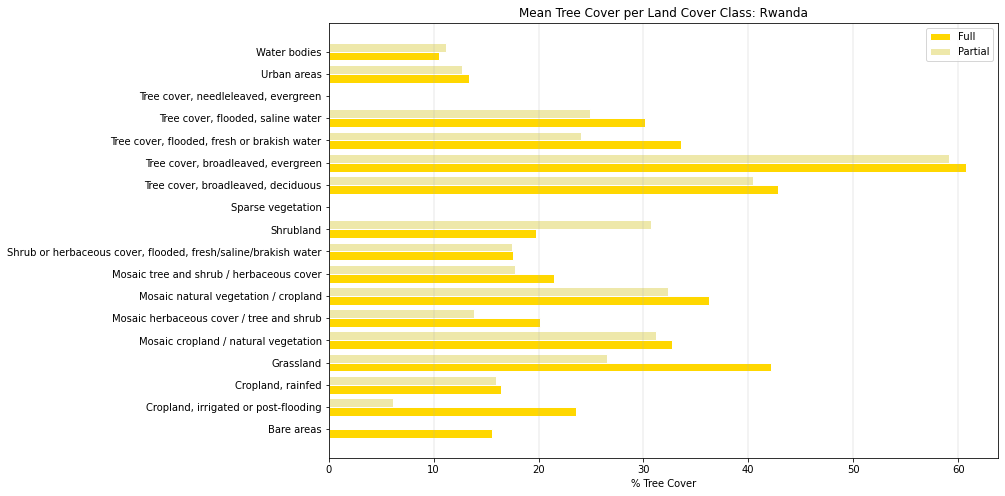

In [3]:
compare_lc_mean('Rwanda')

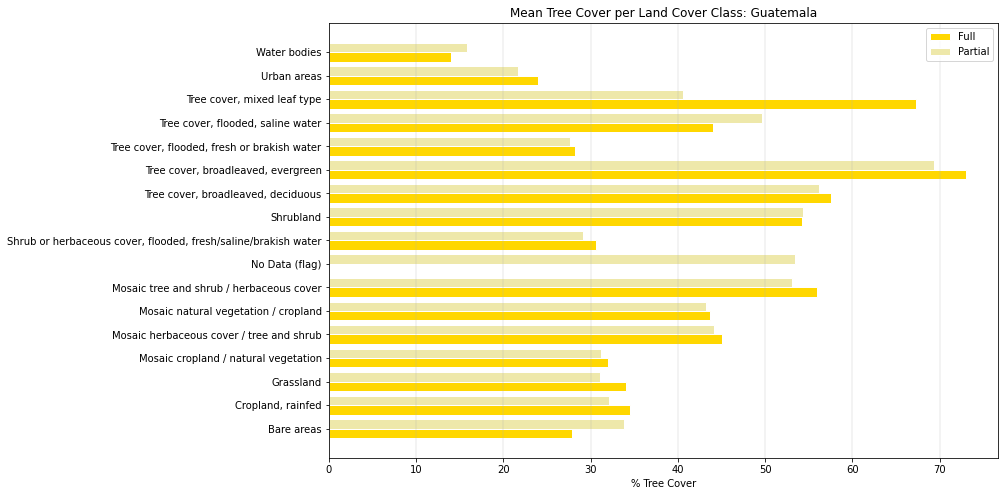

In [4]:
compare_lc_mean('Guatemala')

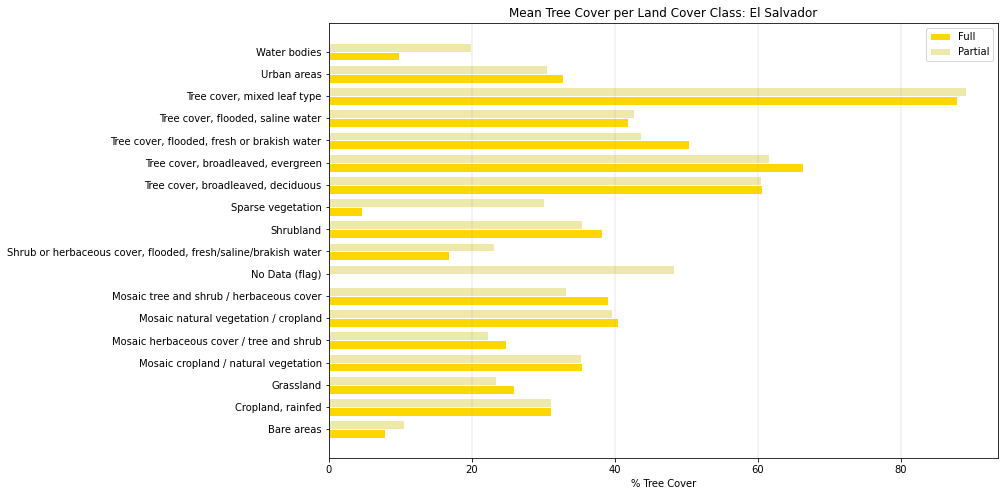

In [5]:
compare_lc_mean('El Salvador')

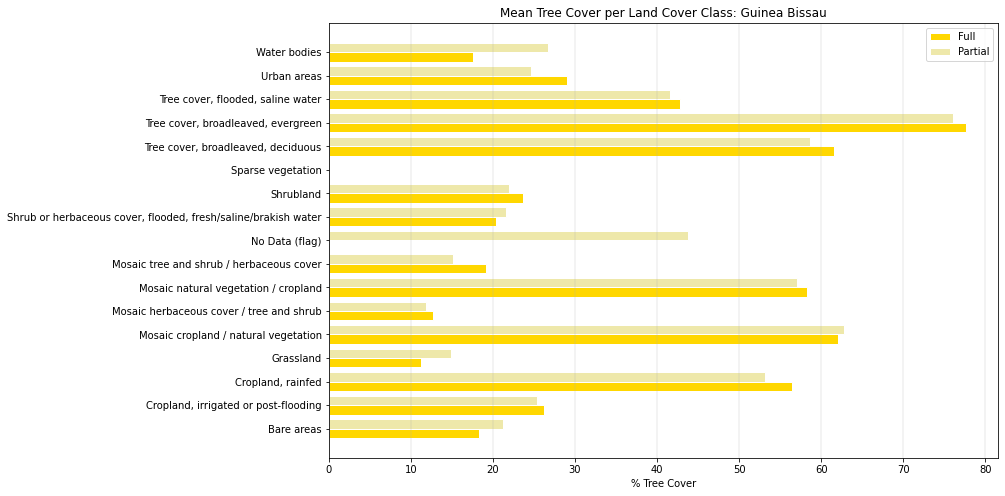

In [6]:
compare_lc_mean('Guinea Bissau')

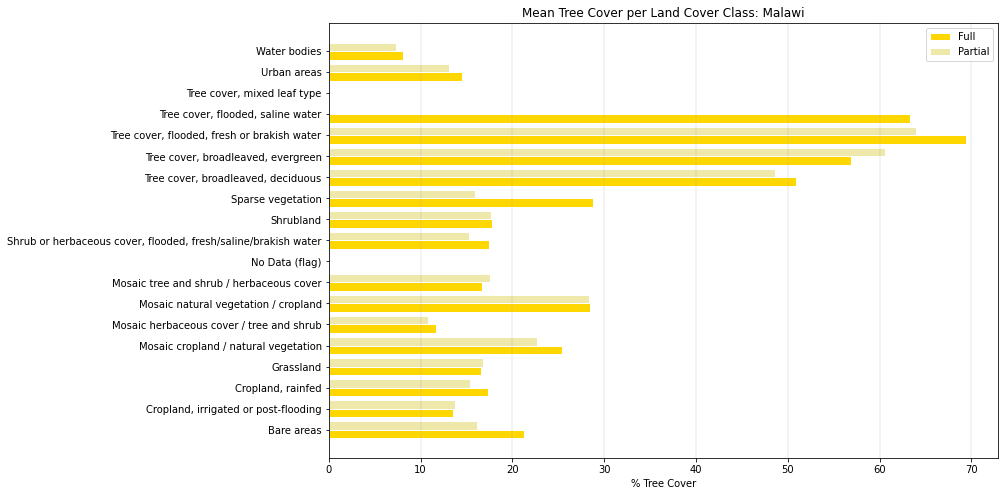

In [7]:
compare_lc_mean('Malawi')

## Forest Cover Compliant

In [69]:
# merge the full processing stats together for all countries

def create_regional_csv(list_of_countries, region):
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        country_df = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
        dfs_to_concat.append(country_df)
    
    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'comparisons/{region}.csv', index=False)
    
    return None

In [70]:
create_regional_csv(['Rwanda', 'Guinea Bissau', 'Guatemala', 'El Salvador', 'Malawi'], 'full_partial')

In [71]:
def compare_forest_cover_compliant(region, figsize):
    
    region_df = pd.read_csv(f'comparisons/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels, ag_bar1, ag_bar2, urban_bar1, urban_bar2 = [],[],[],[],[]
    
    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
        urban_ids = [190.0]
        ag_df = country_df[country_df.esa_id.isin(ag_ids)].sort_values('country')
        urban_df = country_df[country_df.esa_id.isin(urban_ids)].sort_values('country')
        
        # get total tof ha per tree cover threshold
        ag_df = ag_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        ag_df = ag_df[['country', 'tree_cover_class', 'tof_ha']] 
        urban_df = urban_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        urban_df = urban_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        ag_under10 = ag_df.tof_ha[0]
        ag_over10 = sum(ag_df.tof_ha[1:])
        urban_under10 = urban_df.tof_ha[0]
        urban_over10 = sum(urban_df.tof_ha[1:])
        
        # normalize
        ag_under10_norm = ag_under10/(ag_under10 + ag_over10)*100
        ag_over10_norm = ag_over10/(ag_under10 + ag_over10)*100
        urban_under10_norm = urban_under10/(urban_under10 + urban_over10)*100
        urban_over10_norm = urban_over10/(urban_under10 + urban_over10)*100
        
        x_labels.append(country)
        ag_bar1.append(ag_over10_norm) # >10% is on the bottom
        ag_bar2.append(ag_under10_norm) # <10% is on the top
        urban_bar1.append(urban_over10_norm) 
        urban_bar2.append(urban_under10_norm) 
   
    # convert to array in order to add data labels
    ag_bar1 = np.asarray(ag_bar1)
    ag_bar2 = np.asarray(ag_bar2)
    urban_bar1 = np.asarray(urban_bar1)
    urban_bar2 = np.asarray(urban_bar2)

    plt.figure(figsize=figsize)
        
    # Ag plot
    plt.subplot(1,2,1)
    plt.bar(x_labels, ag_bar1, color="seagreen", label='>10% tree cover', capsize=4)  
    plt.bar(x_labels, ag_bar2, bottom=ag_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, ag_bar1/2, ag_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, ag_bar1 + ag_bar2/2, ag_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    
    # Urban plot
    plt.subplot(1,2,2)
    plt.bar(x_labels, urban_bar1, color="seagreen", label='>10% tree cover', capsize=4)  
    plt.bar(x_labels, urban_bar2, bottom=urban_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, urban_bar1/2, urban_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, urban_bar1 + urban_bar2/2, urban_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Urban Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    plt.tight_layout(); 

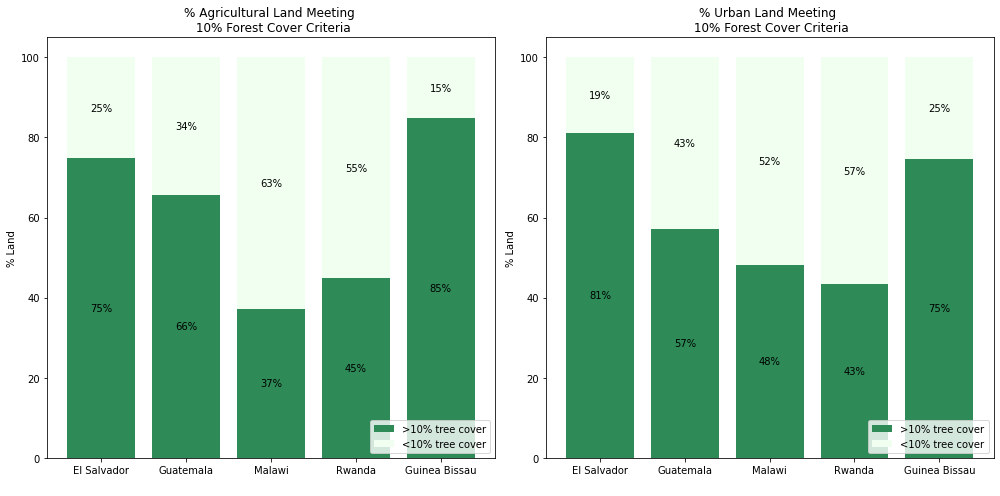

In [72]:
compare_forest_cover_compliant('full_partial', (14,7))

## El Salvador Comparisons (partial versus full)

Partial: 1283182.9 ha of El Salvador sampled.
Full: 3628909.0 ha of El Salvador sampled.


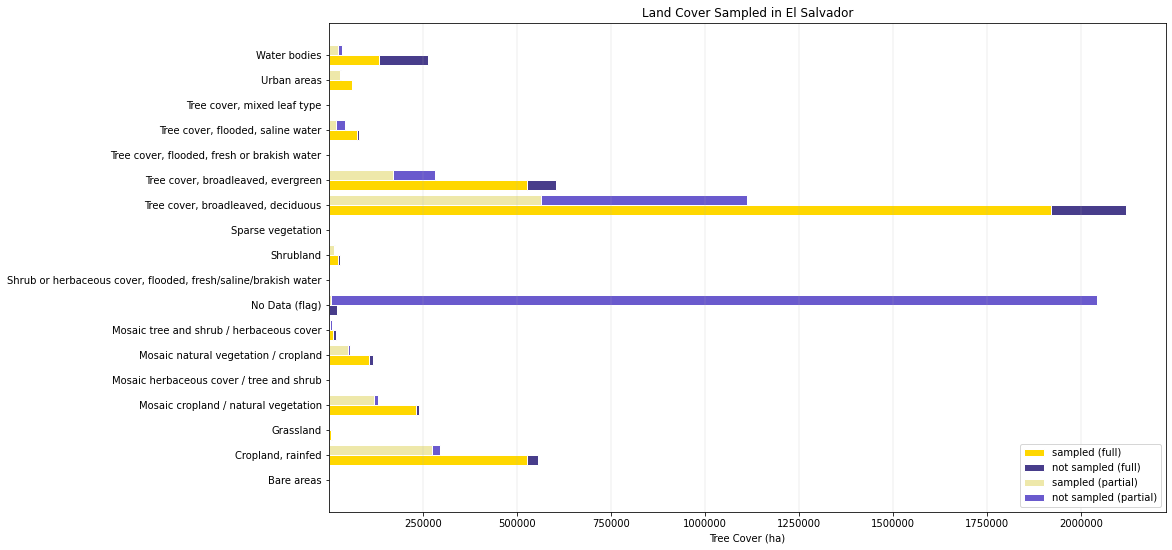

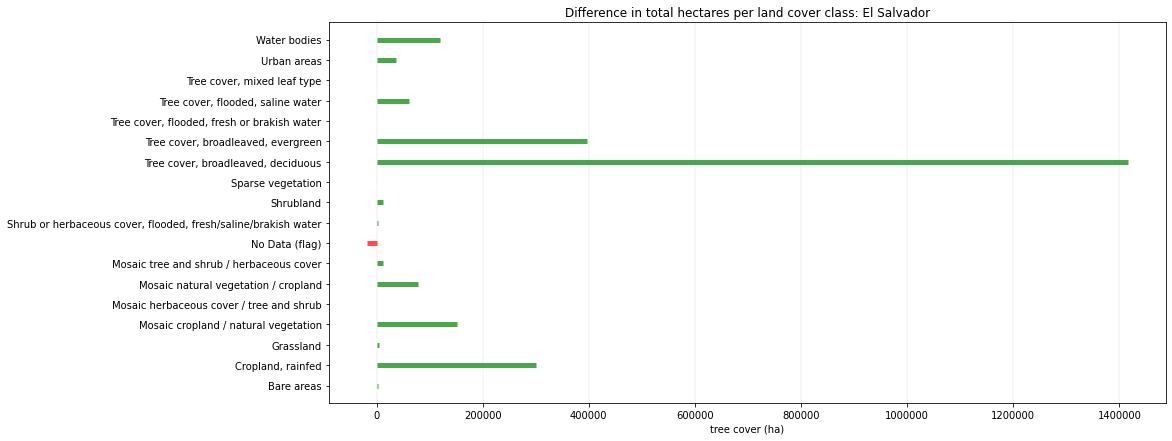

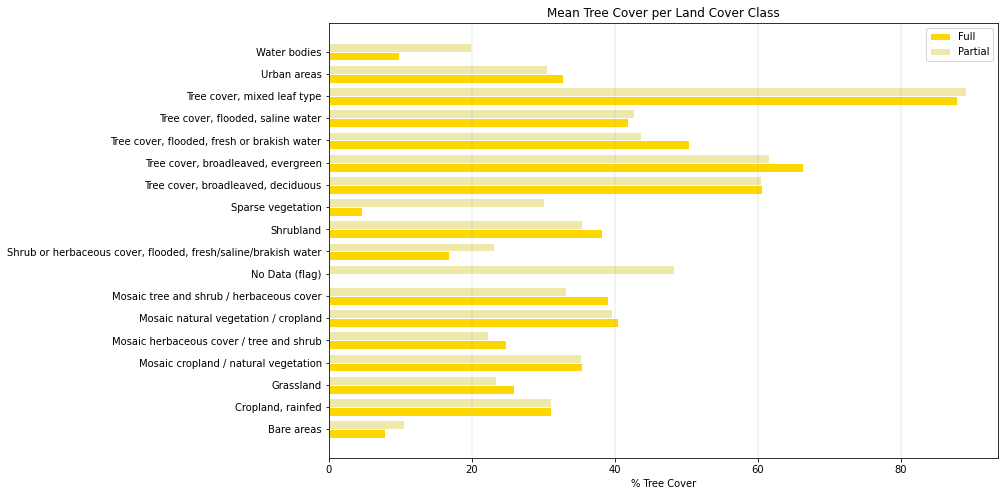

In [73]:
compare_lc_sampled('El Salvador')
compare_lc_totalha('El Salvador')
compare_lc_mean('El Salvador')